In [1]:
import random
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np

In [2]:
inputData=pd.DataFrame.from_csv('input.csv',header=0,index_col=None)
options=[(0,0),(0,1),(1,0),(1,1)]

In [3]:
inputData.head()

,Tout,Solar,speed,load
0,20.795,180,2.1,1.430594
1,20.190,138,4.6,3.872390
2,20.185,265,3.6,2.643595
3,20.780,424,4.1,3.189349
4,20.775,418,4.1,3.206914


In [4]:
# The simplified Building Model #

class sys:
    def __init__(self):
        self.Tin=22
        self.p_solar=0.0002
        self.p_env=0.1
        self.Q_AC=2
        self.p_nv=0.8
        self.p_load=0.5

        self.optimal=23
        self.optimal_range=2
        self.E=0
        self.E_step=0
        self.discomfort_step=0
        
        self.Q_laststep=0
        
        self.Tin_array=[]
        self.Tout_array=[]
        self.AC_array=[]
        self.win_array=[]
        
        self.cost_E=1
        self.cost_D=1
        self.reward_step=0
        
    def update(self, Tout,solar,windSpeed,Q_load, win=False, AC=False):
        """The physical process in the room"""
        
        # Heat transfer through envelop
        Q_env=(Tout-self.Tin)*self.p_env
        
        # Heat generated inside
        Q_in=Q_load*self.p_load
        
        # Heat by AC
        Q_AC=-self.Q_AC*AC
        
        # Heat by open window
        Q_win=self.p_nv*(Tout-self.Tin)*((0.1*windSpeed)**2+(0.1*(Tout-self.Tin))**2)**0.5*win
        
        # Heat by solar
        Q_solar=self.p_solar*solar
        
        # Total heat
        Q_total=Q_env+Q_in+Q_AC+Q_win+Q_solar
        
        # Temperature delta
        delta_T=0.7*Q_total+self.Q_laststep
        
        # Delayed temperature change
        self.Q_laststep=0.3*Q_total
        
        # Update Tin
        self.Tin+=delta_T
                
        # append Tin
        self.Tin_array.append(self.Tin)
        
        # record action
        self.AC_array.append(AC)
        self.win_array.append(win)
        self.Tout_array.append(Tout)
        
        # Electricity
        self.E_step=AC
        self.E+=self.E_step
        
        # Discomfort
        if abs(self.Tin-self.optimal)>self.optimal_range:
            self.discomfort_step=1000*(self.Tin-self.optimal)**2            
        else:
            self.discomfort_step=(self.Tin-self.optimal)**2
        
        # step reward
        self.reward_step=-1*(self.cost_E*self.E_step+self.cost_D*self.discomfort_step)
            
        return
    
    def get_summary(self):
        ans = -1*self.cost_D*sum((np.array(self.Tin_array)-self.optimal)**2) + self.cost_E*self.E
        return ans

In [5]:
# Q-learning #

Q_learn_table={}
discount=0.9

def getQValue(state,action):
    if (state,action) not in Q_learn_table:
        return 0
    else:
        return Q_learn_table[(state,action)]

def computeValueFromQValue(state):
    maxQ=-float('inf')
    for action in options:
        Q=getQValue(state,action)
        if Q>maxQ:
            maxQ=Q
    if maxQ==-float('inf'):
        return 0
    return maxQ

def computeActionFromQValue(state):
    bestAction = None
    maxQ=-float('inf')

    for action in options:
        Q=getQValue(state,action)
        if Q>maxQ:
            maxQ=Q
            bestAction=action
    return bestAction

def getAction(state):
    r=random.random()
    if r<epsilon:
        action = random.choice(options)
    else:
        action = computeActionFromQValue(state)
    return action

def update(state, action, nextState,reward):
    Q=getQValue(state, action)
    Q_learn_table[(state,action)]=(1-alpha)*Q+alpha*(reward+discount*computeValueFromQValue(nextState))
             

In [6]:
# simulation using Q_learning #

result=[]
for episode in range(400):
    epsilon=max(0,1-0.004*episode)
    alpha=max(0,0.6-0.002*episode)
    system=sys()
    for weather in inputData.values:
        for timestep in range(1):
            state=(round(weather[0]),weather[1]//50,round(weather[2]),round(system.Tin))
            action=getAction(state)
            system.update(weather[0],weather[1],weather[2],weather[3],action[0],action[1])
            nextState=(round(weather[0]),weather[1]//50,round(weather[2]),round(system.Tin))
            reward=system.reward_step
            update(state,action,nextState,reward)
            
    result.append(system.get_summary())

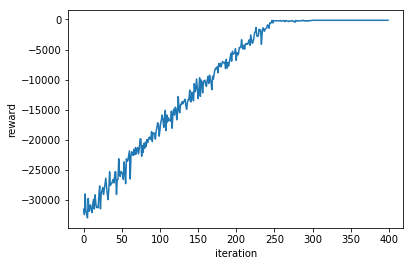

In [7]:
plt.plot(result)
plt.xlabel("iteration")
plt.ylabel("reward")
plt.show()

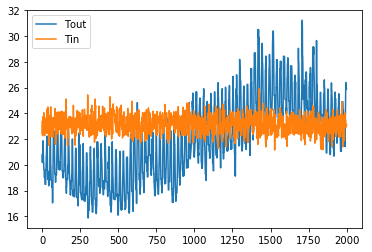

In [8]:
plt.plot(system.Tout_array)
plt.plot(system.Tin_array)
plt.legend(["Tout","Tin"])
plt.show()

In [9]:
# total electricity #
system.E

783

In [10]:
# total discomfort #
sum((np.array(system.Tin_array)-system.optimal)**2)

915.91644238428125

In [11]:
# heuristic control #

system=sys()

for weather in inputData.values:
    for timestep in range(1):
        if system.Tin>system.optimal:
            AC=True
        else:
            AC=False
        
        if weather[0]<system.optimal and weather[0]>21:
            win=True
        else:
            win=False
        
        system.update(weather[0],weather[1],weather[2],weather[3],win,AC)

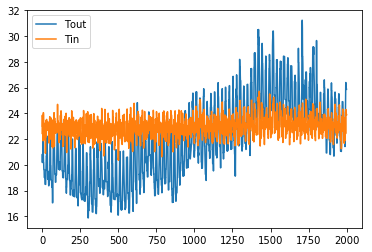

In [12]:
plt.plot(system.Tout_array)
plt.plot(system.Tin_array)
plt.legend(["Tout","Tin"])
plt.show()

In [13]:
# total electricity #
system.E

915

In [14]:
# total discomfort #
sum((np.array(system.Tin_array)-system.optimal)**2)

1451.3788467424988

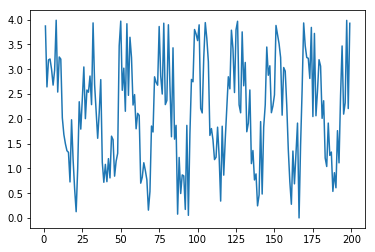

In [15]:
# actural internal load #

plt.plot(inputData['load'][1:200])
plt.show()

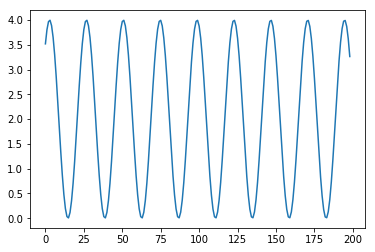

In [16]:
# Estimated internal load #

t=np.linspace(0,2000,2000)
plt.plot((np.sin(t*np.pi/12  + 0.6) * 2 + 2)[1:200])
plt.show()

In [17]:
# model predictive control #

def load_hat(i):
    return (np.sin(i*np.pi/12  + 0.6) * 2 + 2)

def mpc_update(i,k,Tin):
    sys_mpc=sys()
    sys_mpc.Tin=Tin
    sys_mpc.update(weather[i][0],weather[i][1],weather[i][2],load_hat(i),options[k][0],options[k][1])
    return (sys_mpc.Tin, sys_mpc.reward_step)  

def optimize(i, Tin):
    """ optimizor for mpc by brute force"""

    best=-1*float('inf')
    action = [None, None]
    
    weather=inputData.values

    if i>len(weather)-3:
        for k in range(4):
            T_updated, current_r=mpc_update(i,k,Tin)
            if current_r>best:
                best=current_r
                action=k
    else:
    ## two steps look ahead ##
        for k in range(4):
            reward=0
            T_updated, current_r = mpc_update(i,k,Tin)
            reward+=current_r
            for j in range(4):
                T_updated, current_r = mpc_update(i+1,j,T_updated)
                reward+=current_r
                if reward>best:
                    best=reward
                    action=k 

    return action

In [18]:
# simulation using MPC #

system=sys()
weather=inputData.values
for i in range(len(weather)-1):
    index=optimize(i,system.Tin)
    action=options[index]
    system.update(weather[i][0],weather[i][1],weather[i][2],weather[i][3],action[0],action[1])

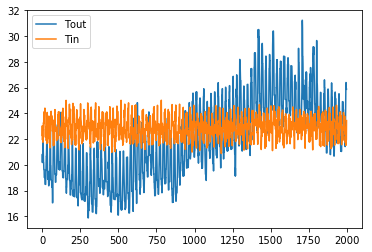

In [19]:
plt.plot(system.Tout_array)
plt.plot(system.Tin_array)
plt.legend(["Tout","Tin"])
plt.show()

In [20]:
# total electricity #
system.E

801

In [21]:
# total discomfort #
sum((np.array(system.Tin_array)-system.optimal)**2)

1225.1216604728893